<a href="https://colab.research.google.com/github/Rmejiaz/AnaliticadeDatos/blob/master/lfw_people_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de Datos - Implementación de redes neuronales sobre el dataset lfw_people y comparación con los métodos de aprendizaje clásicos

### Rafael Mejía Zuluaga
### rmejiaz@unal.edu.co

En el presente cuaderno se analizan los resultados de una tarea de clasificación de imágenes de dos arquitecturas diferentes de redes neuronales, una profunda y otra convolucional, además se realiza una comparación de los resultados con el algoritmo de regresión logística. Todo esto utilizando el dataset lfw_people

In [ ]:
# Importamos las librerías principales

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict

print("Versión de TensowFlow:",tf.__version__)

# Descarga del dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


# Decargar un .py con funciones 
FILEID = "13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O funciones.py && rm -rf /tmp/cookies.txt


from funciones import plot_confusion_matrix

Versión de TensowFlow: 2.2.0


--2020-07-14 23:17:04--  https://docs.google.com/uc?export=download&confirm=&id=13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R
Resolving docs.google.com (docs.google.com)... 74.125.204.100, 74.125.204.113, 74.125.204.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.204.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-3c-docs.googleusercontent.com/docs/securesc/4eqvfgrdoceg8p7c3uarndr0rebehv2o/gnv4kpdpk0dniqiafdh9lu21at5ovhuf/1594768575000/10854142796765961935/08767419310725876291Z/13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R?e=download [following]
--2020-07-14 23:17:05--  https://doc-10-3c-docs.googleusercontent.com/docs/securesc/4eqvfgrdoceg8p7c3uarndr0rebehv2o/gnv4kpdpk0dniqiafdh9lu21at5ovhuf/1594768575000/10854142796765961935/08767419310725876291Z/13oRPB2Aw9ACdOqxm04DGReSlKoLueu9R?e=download
Resolving doc-10-3c-docs.googleusercontent.com (doc-10-3c-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to 

In [ ]:
### Separamos el dataset en un conjunto de train y otro de test

Xdata = lfw_people.images
y = lfw_people.target

Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.2)   # Se hace una partición del 20% para poder tener más datos con los cuales entrenar

#Normalizamos los datos - Para utilizar algoritmos de aprendizaje, ya sea machine learning o deep learning es importante escalar las caracterísiticas para que estas sean comparables

Xtrain = Xtrain/255
Xtest = Xtest/255

## Visualización de algunas muestras con su etiqueta

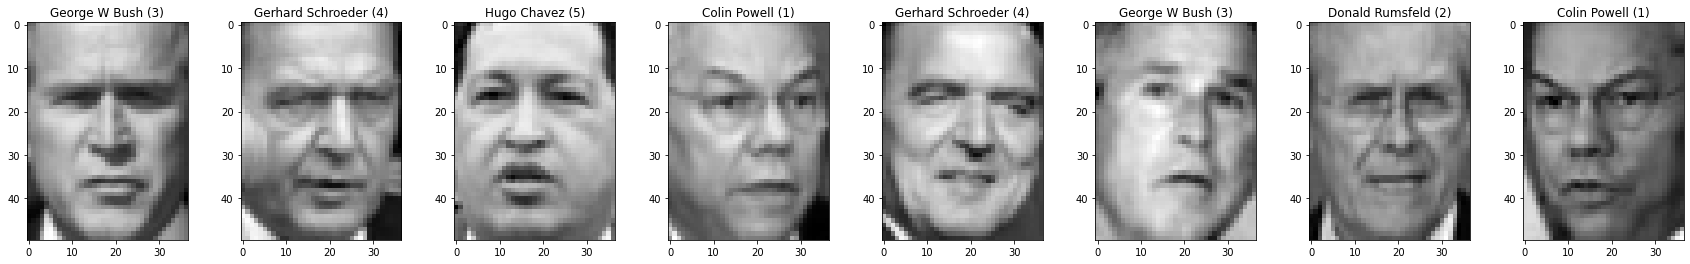

In [ ]:
plt.figure(figsize=(30,4))
for i in range(8):
  plt.subplot(1,8,i+1)
  plt.imshow(Xtrain[i],cmap='gray')
  title = (lfw_people.target_names[ytrain[i]]) + ' ('+ str(ytrain[i]) + ')'
  plt.title(title)

# Red Neuronal Profunda

## Entrenamiento y validación

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 50, 37)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 1850)              0         
_________________________________________________________________
Hidden1 (Dense)              (None, 117)               216567    
_________________________________________________________________
dropout (Dropout)            (None, 117)               0         
_________________________________________________________________
Hidden2 (Dense)              (None, 87)                10266     
_________________________________________________________________
dropout_1 (Dropout)          (None, 87)                0         
_________________________________________________________________
output (Dense)               (None, 7)                 616   

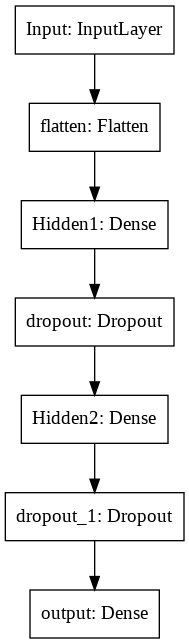

In [ ]:
tf.keras.backend.clear_session()


#Se probaron varias combinaciones de numeros de capas, unidades y funciones de activación. Finalmente, esta fue una de las mejores combinaciones:

l1 = 1e-6
l2 = 1e-4

input_l = tf.keras.layers.Input(shape=([Xtrain.shape[1],Xtrain.shape[2]]), name='Input')
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)
hidden1 = tf.keras.layers.Dense(117,activation='sigmoid',name='Hidden1',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flatten)   # Normalemente la activación ReLU es la más utilizada en imágenes, sin embargo -
drop_1 = tf.keras.layers.Dropout(0.2)(hidden1)       #Para estresar el modelo y así prevenir overfitting                                          - luego de hacer pruebas se tuvieron buenos resultados con la activación sigmoid 
hidden2 = tf.keras.layers.Dense(87,activation='relu',name='Hidden2',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(drop_1)
drop_2 = tf.keras.layers.Dropout(0.2)(hidden2)

output = tf.keras.layers.Dense(7,activation='softmax',name='output')(drop_2)     # La activación de la última capa debe ser softmax, pues es un problema multiclase

model = tf.keras.Model(inputs=input_l,outputs=output)

model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

history = model.fit(Xtrain,ytrain,epochs=60,batch_size=64, validation_split = 0.2)

Epoch 1/60
13/13 [==============================] - 0s 22ms/step - loss: 1.8392 - accuracy: 0.3726 - val_loss: 1.6700 - val_accuracy: 0.4175
Epoch 2/60
13/13 [==============================] - 0s 8ms/step - loss: 1.7477 - accuracy: 0.4175 - val_loss: 1.7011 - val_accuracy: 0.4175
Epoch 3/60
13/13 [==============================] - 0s 8ms/step - loss: 1.7478 - accuracy: 0.4260 - val_loss: 1.6877 - val_accuracy: 0.4175
Epoch 4/60
13/13 [==============================] - 0s 8ms/step - loss: 1.7159 - accuracy: 0.4235 - val_loss: 1.6586 - val_accuracy: 0.4175
Epoch 5/60
13/13 [==============================] - 0s 8ms/step - loss: 1.7009 - accuracy: 0.4211 - val_loss: 1.6416 - val_accuracy: 0.4175
Epoch 6/60
13/13 [==============================] - 0s 9ms/step - loss: 1.6809 - accuracy: 0.4308 - val_loss: 1.6310 - val_accuracy: 0.4466
Epoch 7/60
13/13 [==============================] - 0s 8ms/step - loss: 1.6412 - accuracy: 0.4393 - val_loss: 1.5689 - val_accuracy: 0.4757
Epoch 8/60
13/13 [=

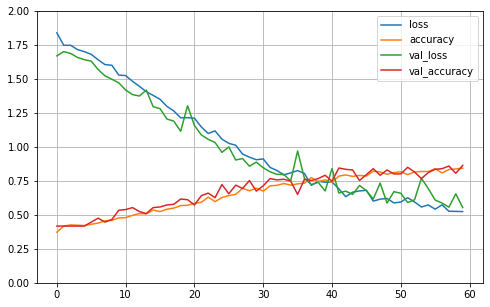

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
#save_fig("keras_learning_curves_plot")
plt.show()

## Análisis de Resultados

## Pesos de la primera capa de la red

Es una representación de la relevancia de cada cara, nos permite ver a que zonas de las imágenes le dio más importancia la red.

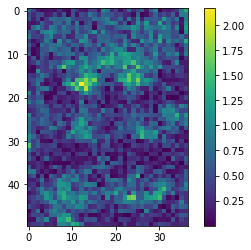

In [ ]:
plt.imshow(abs(model.layers[2].get_weights()[0].sum(axis=1).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2])))
plt.colorbar()
plt.show()

## Evaluación

In [ ]:
# Evaluar el modelo sobre el conjunto de test

model.evaluate(Xtest,ytest)

9/9 [==============================] - 0s 2ms/step - loss: 0.7965 - accuracy: 0.7829


[0.7965264916419983, 0.7829457521438599]

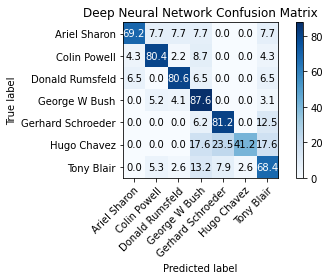

              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.82      0.80      0.81        46
           2       0.78      0.81      0.79        31
           3       0.84      0.88      0.86        97
           4       0.65      0.81      0.72        16
           5       0.88      0.41      0.56        17
           6       0.67      0.68      0.68        38

    accuracy                           0.78       258
   macro avg       0.76      0.73      0.73       258
weighted avg       0.79      0.78      0.78       258



In [ ]:
y_pred = model.predict(Xtest)

from sklearn.metrics import  accuracy_score,classification_report


plot_confusion_matrix(y_true=ytest,y_pred=y_pred.argmax(axis=1),classes=lfw_people.target_names,title='Deep Neural Network Confusion Matrix')
plt.show()

print(classification_report(ytest, y_pred.argmax(axis=1)))

## Interpretación de las salidas intermedias de la red (visualización utilizando PCA)

In [ ]:
from sklearn.decomposition import PCA

### Capa h1
model_h1 = tf.keras.Model(inputs=[input_l],outputs=model.get_layer('Hidden1').output)
h1Out = model_h1.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
red1 = PCA()
zh1Out = red1.fit_transform(h1Out) 

### Capa h2
model_h2 = tf.keras.Model(inputs=[input_l],outputs=model.get_layer('Hidden2').output)
h2Out = model_h2.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
red2 = PCA()
zh2Out = red2.fit_transform(h2Out)

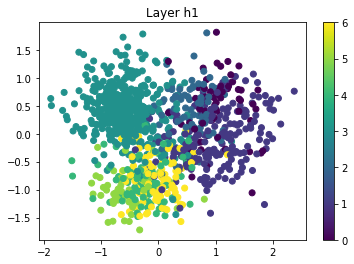

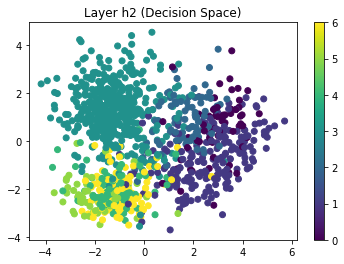

In [ ]:
plt.scatter(zh1Out[:,0],zh1Out[:,1],c=ytrain)
plt.title("Layer h1")
plt.colorbar()
plt.show()

plt.scatter(zh2Out[:,0],zh2Out[:,1],c=ytrain)
plt.title("Layer h2 (Decision Space)")
plt.colorbar()
plt.show()


El rendmiento de la red no es muy bueno, esto lo podemos ver tanto del accuracy como de las salidas parciales, pues en la capa h2, que es sobre la cual la red clasifica no se separan muy bien las clases. Sin embargo, esta arquitectura no es la más óptima que existe para esta tarea, además de que este dataset no cuenta con muchas muestras, pues en este caso estamos entrenando con solo 1030 imágenes. Sin embargo, podemos ver como la clase de Geroge W Bush (3) es la que más separada queda, resultado que de igual manera se ve reflejado en la matriz de confusión y en el recall.

# Red Neuronal Convolucional

Ahora vamos a probar una arquitectura convolucional, pues estas son especialmente útiles para los problemas de visión, ya que con estas arquitecturas, por medio de filtros es posible extraer características de las imágenes antes de pasarlas por una red profunda

Después de hacer varios intentos, lo que mejores resultados dio fue usar unicamente una capa oculta justo después de las convoluciones

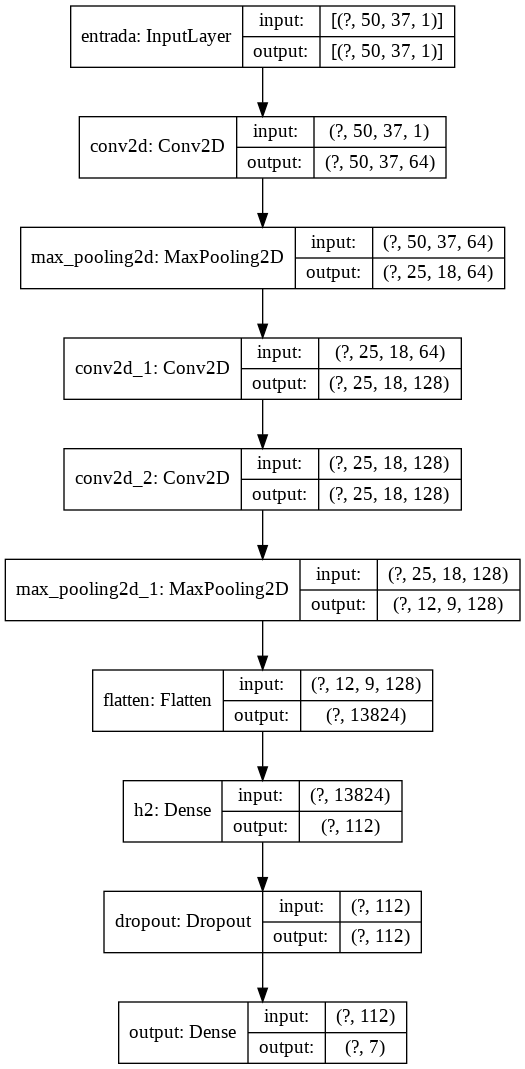

In [ ]:
tf.keras.backend.clear_session()


from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=9, activation='relu', padding="SAME")


l1 = 0.0001
l2 = 0.01

input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2],1),name = 'entrada')
c_layer1 = DefaultConv2D(filters=64, kernel_size=7, input_shape=[Xtrain.shape[1], Xtrain.shape[2], 1])(input_l)
pooling1 = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer1)
c_layer2 = DefaultConv2D(filters=128)(pooling1)
c_layer3 = DefaultConv2D(filters=128)(c_layer2)
pooling2 = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer3)
c_layer4 = DefaultConv2D(filters=128)(pooling2)
c_layer5 = DefaultConv2D(filters=128)(c_layer4)
pooling3 = tf.keras.layers.MaxPooling2D(pool_size=2)(c_layer5)
flatten = tf.keras.layers.Flatten()(pooling2)

h2 = tf.keras.layers.Dense(units=112, activation='relu',name='h2',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flatten)
drop_2 = tf.keras.layers.Dropout(0.7)(h2)   ### Utilizamos una técnica de regularización un poco agresiva, esto con el fin de evitar overfitting y tener una buena generalización

output = tf.keras.layers.Dense(7,activation='softmax',name='output')(drop_2)


CNNmodel = tf.keras.Model(inputs=input_l,outputs=output)

tf.keras.utils.plot_model(CNNmodel,show_shapes=True,show_layer_names=True)

In [ ]:
CNNmodel.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=["accuracy"])

history = CNNmodel.fit(Xtrain,ytrain,epochs=100,batch_size=64, validation_split = 0.3)

Epoch 1/100
12/12 [==============================] - 0s 33ms/step - loss: 4.5550 - accuracy: 0.3426 - val_loss: 3.2417 - val_accuracy: 0.4110
Epoch 2/100
12/12 [==============================] - 0s 24ms/step - loss: 2.8626 - accuracy: 0.3662 - val_loss: 2.5633 - val_accuracy: 0.4110
Epoch 3/100
12/12 [==============================] - 0s 23ms/step - loss: 2.4822 - accuracy: 0.4036 - val_loss: 2.2895 - val_accuracy: 0.4110
Epoch 4/100
12/12 [==============================] - 0s 23ms/step - loss: 2.2370 - accuracy: 0.3953 - val_loss: 2.1215 - val_accuracy: 0.4110
Epoch 5/100
12/12 [==============================] - 0s 23ms/step - loss: 2.1526 - accuracy: 0.3814 - val_loss: 2.0086 - val_accuracy: 0.4110
Epoch 6/100
12/12 [==============================] - 0s 23ms/step - loss: 2.0324 - accuracy: 0.3925 - val_loss: 1.9302 - val_accuracy: 0.4110
Epoch 7/100
12/12 [==============================] - 0s 23ms/step - loss: 1.9436 - accuracy: 0.4119 - val_loss: 1.8794 - val_accuracy: 0.4110
Epoch 

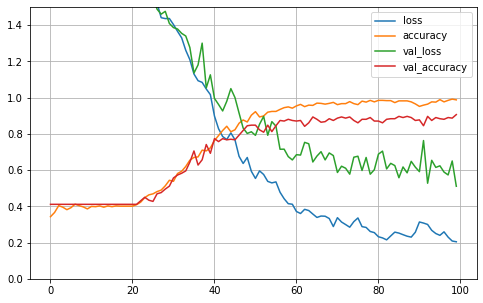

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
#save_fig("keras_learning_curves_plot")
plt.show()

In [ ]:
CNNmodel.evaluate(x=Xtest,y=ytest)

9/9 [==============================] - 0s 4ms/step - loss: 0.7202 - accuracy: 0.9109


[0.7201982736587524, 0.9108527302742004]

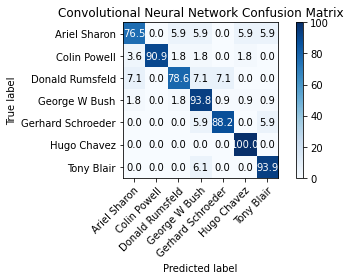

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       1.00      0.91      0.95        55
           2       0.73      0.79      0.76        14
           3       0.95      0.94      0.94       113
           4       0.88      0.88      0.88        17
           5       0.75      1.00      0.86         9
           6       0.91      0.94      0.93        33

    accuracy                           0.91       258
   macro avg       0.85      0.89      0.87       258
weighted avg       0.92      0.91      0.91       258



In [ ]:
y_pred = CNNmodel.predict(Xtest)

from sklearn.metrics import  accuracy_score,classification_report


plot_confusion_matrix(y_true=ytest,y_pred=y_pred.argmax(axis=1),classes=lfw_people.target_names,title='Convolutional Neural Network Confusion Matrix')
plt.show()

print(classification_report(ytest, y_pred.argmax(axis=1)))

## Interpretación de las salidas intermedias de la red (visualización utilizando PCA)

In [ ]:
from sklearn.decomposition import PCA

### Capa h1
#CNNmodel_h1 = tf.keras.Model(inputs=[input_l],outputs=CNNmodel.get_layer('h1').output)
#CNNh1Out = CNNmodel_h1.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
#red1 = PCA()
#zCNNh1Out = red1.fit_transform(CNNh1Out) 

### Capa h2
CNNmodel_h2 = tf.keras.Model(inputs=[input_l],outputs=CNNmodel.get_layer('h2').output)
CNNh2Out = CNNmodel_h2.predict(Xtrain)
#tf.keras.utils.plot_model(model_h1A)
red2 = PCA()
zCNNh2Out = red2.fit_transform(CNNh2Out)

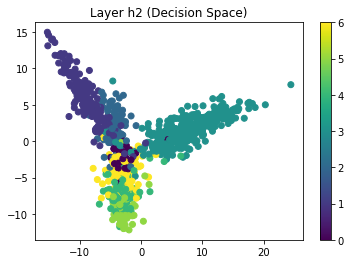

In [ ]:
plt.scatter(zCNNh2Out[:,0],zCNNh2Out[:,1],c=ytrain)
plt.title("Layer h2 (Decision Space)")
plt.colorbar()
plt.show()

Ahora conseguimos un modelo que es muy bueno separando las diferentes clases, tal como lo demuestra la proyección del espacio de clasificación. Logramos pasar de una exactitud del 78% a una del **91%** sobre el conjunto de evaluación. Además de esto, se puede ver la buena separación de algunas de las clases en la proyección del espacio de desición. En clases como la de George W Bush (3) y Collin Powell (1) es muy evidente esta separación. 

## Ejemplo del modelo funcionando

Input:


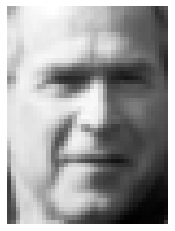

Output:
3 - George W Bush


In [ ]:
sample = 45

print("Input:")
plt.imshow(Xtest[sample],cmap='gray')
plt.axis('off')
plt.show()

pred = CNNmodel.predict(Xtest[sample][np.newaxis,:,:])
print("Output:")
print(pred.argmax(),"-",lfw_people.target_names[pred.argmax()])

## Salida del primer filtro

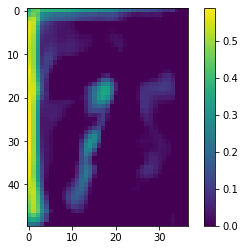

In [ ]:
PartMod1 = tf.keras.Model(inputs=[input_l],outputs=c_layer1)

conv1out = PartMod1.predict(Xtest[sample][np.newaxis,:,:])

plt.imshow(abs(conv1out[0,:,:,0]))
plt.colorbar()
plt.show()

Esto nos permite ver las características que extrajo el primer filtro de la red de una imagen de George W Bush 

# Comparación de resultados con respescto a los algoritmos clásicos

A continuación se presentan los resultados más relevantes obtenidos utilizando los algoritmos clásicos de clasificación, los cuales fueron debidamente comparados en [este cuaderno](https://colab.research.google.com/drive/1vZ1irJlpoTzYDaAdbieQ04sOSy21lJw-?usp=sharing)

Según la comparación realizada, el mejor algoritmo fue el de Regresión Logística, con un **85.5%** de exactitud

## Matriz de confusión

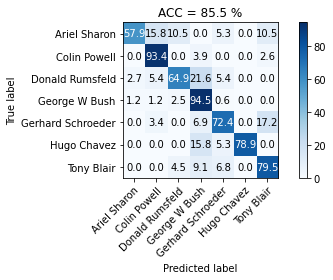


## Reporte de clasificación

                   precision    recall  f1-score   support

    Ariel Sharon       0.79      0.58      0.67        19
    Colin Powell       0.90      0.93      0.92        76
    Donald Rumsfeld    0.75      0.65      0.70        37
    George W Bush      0.89      0.94      0.91       163
    Gerhard Schroeder  0.72      0.72      0.72        29
    Hugo Chavez        1.00      0.79      0.88        19
    Tony Blair         0.80      0.80      0.80        44

         accuracy                          0.86       387
        macro avg       0.83      0.77     0.80       387
     weighted avg       0.85      0.86     0.85       387

Así pues, tenemos los siguientes resultados:

- Red Neuronal Profunda: **78%**
- Red Neuronal Convolucional: **91%**
- Regresión Logística: **86%**

Es claro que el mejor modelo fue el de una red neuronal convolucional, lo cual era de esperarse, pues estas arquitecturas son muy utilizadas para tareas de visión y procesamiento de imágenes, por su capacidad de distinguir formas y objetos en las imágenes, de acuerdo a la cercanía entre píxeles. Esto a diferencia de las redes neuronales profundas, las cuales dan la misma importancia a todos los píxeles de la imagen. Es por esto que el rendimiento de la red profunda fue significativamente inferior al de la red convolucional. 